<a href="https://colab.research.google.com/github/btrinite/robocars_training_notebook/blob/master/Minigrumpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
print("TensorFlow version "+str(tf.__version__))
print("Keras version "+str(keras.__version__))
print("TF source file "+str(tf.__file__))

!pip install tensorflow_model_optimization
!pip install ipywidgets
#Progess Bar

from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


TensorFlow 1.x selected.


Using TensorFlow backend.


TensorFlow version 1.15.2
Keras version 2.3.1
TF source file /tensorflow-1.15.2/python3.6/tensorflow/__init__.py
     |████████████████████████████████| 174kB 6.0MB/s 
     |████████████████████████████████| 296kB 11.7MB/s 


In [0]:
!pip install -U -q PyDrive
#!pip install --upgrade gcloud
#!pip install --upgrade google-api-python-client

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!mkdir -p data
!mkdir -p models

import os

local_download_path = os.path.expanduser('/content')
try:
  os.makedirs(local_download_path)
except: pass

def ListFolder(parent):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % parent}).GetList()
  for f in file_list:
    print ('title: {} id:{} mimeType:{}'.format(f['title'], f['id'], f['mimeType']))
    if f['mimeType']=='application/vnd.google-apps.folder': # if folder
      ListFolder(f['id'])


def CopyFolder(distant, local):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % distant}).GetList()
  for file1 in file_list:
    print('title: %s, id: %s, mimeType: %s' % (file1['title'], file1['id'], file1['mimeType']))
    if (file1['mimeType'] in ['application/gzip','application/x-gzip','application/x-compressed-tar']):
      fname = os.path.join(local_download_path+'/'+local, file1['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': file1['id']})
      f_.GetContentFile(fname)


In [0]:
roborace_dir_id = '1RuPOwKBRzqNo4gErS5GYhjESvmn2Rs2N'
ListFolder(roborace_dir_id)


title: dataset id:1ZmzY-95bMHzwZfzptVZnv55ZNfU7h-oK mimeType:application/vnd.google-apps.folder
title: mini id:1J0Z0gArVDWVPsQuSnHFSqOId347IfPWA mimeType:application/vnd.google-apps.folder
title: 14-05-2020 id:1wT7Eq_sinRxZ8MJ1NUvvE5b7uXW-BRXA mimeType:application/vnd.google-apps.folder
title: data-14052020.tgz id:1VxwYngfRM4GPMqi61EFnTXLxKhJMi6VM mimeType:application/x-compressed-tar
title: 05-05-2020 id:107BS2XwEiZZujQlvzuEWEUtiezqXL_iP mimeType:application/vnd.google-apps.folder
title: data-05-05-2020.tgz id:1IgU-iaqez83HPpwq9Fp9Akt6wLQR8IUx mimeType:application/x-compressed-tar
title: data-26-04-2020.tgz id:131SfvgAGb6GG9jOTH5WquHydYG3DggIZ mimeType:application/x-compressed-tar
title: data-2020-04-19.tgz id:12EjFgwkTTUb7-QnTX3axX2_NfA2_E4wV mimeType:application/x-compressed-tar
title: race-20200229 id:1SvghnMlIW1E4YAFCNi969onGhnyH-AOe mimeType:application/vnd.google-apps.folder
title: data-2020-02-29_11-20-54.tar.gz id:1zkXmtDaVXWGJeF-B6xWGdqcRkjC6ggBo mimeType:application/gzip
tit

In [0]:
dataset_dir_id = '1wT7Eq_sinRxZ8MJ1NUvvE5b7uXW-BRXA' # mini/14/05
models_dir_id = '1OnkWj_D6RdgiACz1IeD-y4JBX2FlZXqK'


In [0]:
#remove all previous dataset and copy new one
! rm -r -f data
! mkdir -p data
! mkdir -p data/samples
! mkdir -p models
CopyFolder (dataset_dir_id, 'data')
! ls data


title: data-14052020.tgz, id: 1VxwYngfRM4GPMqi61EFnTXLxKhJMi6VM, mimeType: application/x-compressed-tar
downloading to /content/data/data-14052020.tgz
data-14052020.tgz  samples


In [0]:
# Uncompress and count images
! for file in data/*.tgz; do tar --warning=none -zxf $file -C ./data/samples; done
! ls -R data/samples  | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/' 
! find data/samples/ | grep jpg | wc -l

   |-samples
   |---d2-tmpfs
   |-----data
   |-------2020-05-14-user-01
11284


In [0]:
#settings
import datetime
now = datetime.datetime.now()

# model name
model_name = "model_lin_"+'{:02d}'.format(now.day)+'{:02d}'.format(now.month)+'{:04d}'.format(now.year)

#source directory
data_dir = 'data/samples'
model_file_base = './models/'+model_name

captured_pool_size_ratio = 1.0
augmentation_pool_size_ratio = 1.0

process_postprocess = ""

process_augmentation = 1
process_flip = 1
process_brightness = 1
process_sunray = 0
process_shift = 1
process_light = 0

shuffleAtTheEnd = False

ROI_x_min = 0
ROI_x_max = 159
ROI_y_min = 40
ROI_y_max = 120
roi_top_bottom_crop = (ROI_y_min, 120-ROI_y_max)



In [0]:
#import metadta
import os
import json
import re
numbers = re.compile(r'(\d+)')
full_raw_capt_data = []
capt_data = []

def get_data(root, f):
    d = json.load(open(os.path.join(root,f)))
    ret = [d['mode'],d['throttle'],d['angle'],d['mark'],root,d['cam/image_array']]
    if ('flag' in d):
        ret.extend([d['flag']])
    return ret
        
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
    
for root, dirs, files in os.walk(data_dir):
    full_raw_capt_data.extend([get_data(root, f) for f in sorted(files, key=numericalSort) if f.startswith('front') and f.endswith('.json')])
    print(len(full_raw_capt_data))

print("Total : "+str(len(full_raw_capt_data)))
capt_data = full_raw_capt_data[0:int(captured_pool_size_ratio*len(full_raw_capt_data))]
print("Used for training: "+str(len(capt_data)))


0
0
0
11284
Total : 11284
Used for training: 11284


In [0]:
# Import images 
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageOps
import numpy as np

capt_images_pil = []

import cv2

filtered_cap_data = []
for idx, d in enumerate(capt_data):
    filtered_cap_data.append(d)
    img = Image.open(os.path.join(d[4],d[5]))
    # Option 1, Just append images to PIL
    
    capt_images_pil.append(img.copy())
    img.close()

print (len(capt_images_pil))


11284


['user', 0.829421, -0.352113, 1, 'data/samples/d2-tmpfs/data/2020-05-14-user-01', 'front00006000.jpg']


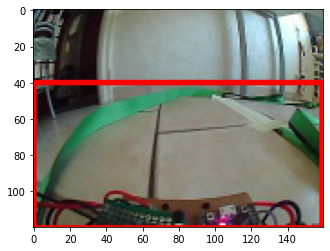

In [0]:
#Show image
import matplotlib.pyplot as plt
start_point = (ROI_x_min, ROI_y_min) 
end_point = (ROI_x_max, ROI_y_max) 
color = (255, 0, 0) 
thickness = 2
aImg=6000
image = cv2.rectangle(np.array(capt_images_pil[aImg]), start_point, end_point, color, thickness) 
plt.imshow(image)
print(capt_data[aImg])


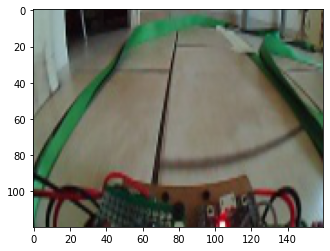

In [0]:
def processROI (img):
  cropped_image = img[ROI_y_min:(ROI_y_min+(ROI_y_max-ROI_y_min+1)), ROI_x_min:(ROI_x_min+(ROI_x_max-ROI_x_min+1))]
  newimg = cv2.resize(cropped_image,(int(160),int(120)))
  return newimg
  
plt.imshow(processROI(np.array(capt_images_pil[400])))

In [0]:
# process pre-processing (ROI) 
#out = display(progress(0, 100), display_id=True)
#preprocessed_images_pil = []
#print ("Image PIL size :"+str(len(capt_images_pil)))
#orig_data_size = len(filtered_cap_data)
#for idx in range (0, int(orig_data_size)):
#    out.update(progress(idx, int(orig_data_size)))
#    preprocessed_images_pil.append(Image.fromarray(processROI(np.array(capt_images_pil[idx]))).convert("RGB"))

preprocessed_images_pil = capt_images_pil
print ("Preprocessed Image PIL size :"+str(len(preprocessed_images_pil)))

Preprocessed Image PIL size :11284


In [0]:
# Post augmentation processing dev
import cv2
import numpy as np
import random
from scipy.stats import norm
from sklearn.cluster import KMeans
from collections import Counter
import cv2 #for resizing image

def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)
    
def histEqual(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result
    

def _decayed_value_in_norm(x, max_value, min_value, center, range):
    """
    decay from max value to min value following Gaussian/Normal distribution
    """
    radius = range / 3
    center_prob = norm.pdf(center, center, radius)
    x_prob = norm.pdf(x, center, radius)
    x_value = (x_prob / center_prob) * (max_value - min_value) + min_value
    return x_value
def _decayed_value_in_linear(x, max_value, padding_center, decay_rate):
    """
    decay from max value to min value with static linear decay rate.
    """
    x_value = max_value - abs(padding_center - x) * decay_rate
    if x_value < 0:
        x_value = 1
    return x_value

def generate_parallel_light_mask(mask_size,
                                 position=None,
                                 direction=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None):
    """
    Generate decayed light mask generated by light strip given its position, direction
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: tuple of integers (x, y) defining the center of light strip position,
                  which is the reference point during rotating
        direction: integer from 0 to 360 to indicate the rotation degree of light strip
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
    Return:
        light_mask: ndarray in float type consisting value from 0 to strength
    """
    if position is None:
        pos_x = random.randint(0, mask_size[0])
        pos_y = random.randint(0, mask_size[1])
    else:
        pos_x = position[0]
        pos_y = position[1]
    if direction is None:
        direction = random.randint(0, 360)
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.2, 2)
        if mode == "linear_dynamic":
            linear_decay_rate = (max_brightness - min_brightness) / max(mask_size)
    assert mode in ["linear_dynamic", "linear_static", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    padding = int(max(mask_size) * np.sqrt(2))
    # add padding to satisfy cropping after rotating
    canvas_x = padding * 2 + mask_size[0]
    canvas_y = padding * 2 + mask_size[1]
    mask = np.zeros(shape=(canvas_y, canvas_x), dtype=np.float32)
    # initial mask's up left corner and bottom right corner coordinate
    init_mask_ul = (int(padding), int(padding))
    init_mask_br = (int(padding+mask_size[0]), int(padding+mask_size[1]))
    init_light_pos = (padding + pos_x, padding + pos_y)
    # fill in mask row by row with value decayed from center
    for i in range(canvas_y):
        if mode == "linear":
            i_value = _decayed_value_in_linear(i, max_brightness, init_light_pos[1], linear_decay_rate)
        elif mode == "gaussian":
            i_value = _decayed_value_in_norm(i, max_brightness, min_brightness, init_light_pos[1], mask_size[1])
        else:
            i_value = 0
        mask[i] = i_value
    # rotate mask
    rotate_M = cv2.getRotationMatrix2D(init_light_pos, direction, 1)
    mask = cv2.warpAffine(mask, rotate_M, (canvas_x,  canvas_y))
    # crop
    mask = mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]]
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 9)
    mask = 255 - mask
    # cv2.circle(mask, init_light_pos, 1, (0, 0, 255))
    # cv2.imshow("crop", mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]])
    # cv2.imshow("all", mask)
    # cv2.waitKey(0)
    return mask

def add_parallel_light(frame, light_position=None, direction=None, max_brightness=255, min_brightness=0,
                       mode="gaussian", linear_decay_rate=None, transparency=None):
    """
    Add mask generated from parallel light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_parallel_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        direction=direction,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

def postprocess_img(img, toApply):
    treatments = toApply.split('+')
    for treatment in treatments:
        if (treatment == "GRAY"):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if (treatment == "BLUR"):
            img = cv2.blur(img,(5,5))
        if (treatment == "HIST"):
            img = histEqual(img)
        if (treatment == "ADAPTATIVHIST"):
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
        if (treatment == "SOBELXY"):
            sobelx = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=3)
            sobely = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=3)
            img = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0) 
        if (treatment == "SOBELXYABS"):
            sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
            abs_sobelx64f = np.absolute(sobelx64f)
            sobelx = np.uint8(abs_sobelx64f)
            sobely64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
            abs_sobely64f = np.absolute(sobely64f)
            sobely = np.uint8(abs_sobely64f)
            img = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0) 
        if (treatment == "GAUSBLUR"):
            img = cv2.GaussianBlur(img, (3, 3), 0, 0, cv2.BORDER_DEFAULT);
        if (treatment == "MEDBLUR"):
            img = cv2.medianBlur(img, 5);
        if (treatment == "BILAT"):
            img = cv2.bilateralFilter(img, 9, 75, 75, cv2.BORDER_DEFAULT);
        if (treatment == "BILAT2"):
            img = cv2.bilateralFilter(img, 72, 150, 150, cv2.BORDER_DEFAULT);
        if (treatment == "LIGHT"):
          img = add_parallel_light(img, max_brightness=192, min_brightness=16, mode="gaussian")
        if (treatment == "GLARESREMOVAL"):
          color = get_dominant_color (img)
          mask_image = np.zeros(img.shape[0:2], np.uint8)    
          imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          ret, thresh = cv2.threshold(imgray, 150, 255, cv2.THRESH_BINARY)
          contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(img, contours, -1, color, 15)
        if (treatment == "HIGHLIGHTBIG"):
          imgBlur = cv2.medianBlur(img,5)
          imgGray = cv2.cvtColor(imgBlur,cv2.COLOR_BGR2GRAY)
          img = cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 33, -20)
        if (treatment == "INVERTEDGRAY"):
          img2 = ImageOps.solarize(Image.fromarray(img),32)
          img = np.array(ImageOps.grayscale(img2))


    return img

In [0]:
# Process data augmentation if any
import numpy as np
from PIL import ImageEnhance

def flip_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)
  
def add_brightness(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    s = np.random.uniform(s_low, s_high)
    tmpimg = Image.fromarray(img).convert("RGB")
    contrast = ImageEnhance.Brightness(tmpimg)
    contrast = contrast.enhance(s) 
#    img = img.astype(np.float32)
    return  np.array(contrast)

def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

def add_vertical_random_sunray(img, w_low=0.6, w_high=0.85, r_size_low=5, r_size_h=10):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.uniform(r_size_low, r_size_h)
    top_y_right = top_y + np.random.uniform(r_size_low, r_size_h)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.uniform(r_size_low, r_size_h)
        top_y_right = top_y - np.random.uniform(r_size_low, r_size_h)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (255, 255, 255))
    #masked_image = cv2.bitwise_and(img, mask)
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

def add_horizontal_random_sunray(img, w_low=0.8, w_high=0.95, r_size_low=2, r_size_h=6):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    nb_ray = np.random.randint(1,4)
    space = np.random.randint(10,20)
    ref_left_x = np.random.random_sample() * cols
    ref_right_x = np.random.random_sample() * cols
    ref_left_x_up = ref_left_x + np.random.uniform(r_size_low, r_size_h)
    ref_right_x_up = ref_right_x + np.random.uniform(r_size_low, r_size_h)
    if np.random.random_sample() <= 0.5:
        ref_right_x_up = ref_right_x - np.random.uniform(r_size_low, r_size_h)
        ref_left_x_up = ref_left_x - np.random.uniform(r_size_low, r_size_h)
    new_img=np.copy(img)
    for n in range(0, nb_ray):
      left_x = ref_left_x+(n*space)
      right_x = ref_right_x+(n*space)
      left_x_up = ref_left_x_up+(n*space)
      right_x_up = ref_right_x_up+(n*space)
      poly = np.asarray([[ [0,left_x], [rows, right_x], [rows,right_x_up], [0,left_x_up]]], dtype=np.int32)

      mask_weight = np.random.uniform(w_low, w_high)
      origin_weight = 1 - mask_weight

      mask = np.copy(new_img).astype(np.int32)
      cv2.fillPoly(mask, poly, (255, 255, 255))
      new_img=cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)
    #masked_image = cv2.bitwise_and(img, mask)
    return new_img
  
# Read more about it here: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    """
    Shifts the image right, left, up or down. 
    When performing a lateral shift, a delta proportional to the pixel shifts is added to the current steering angle 
    """
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range) 
    translation_y = np.random.randint(low_y_range, high_y_range) 
    
    st_angle += translation_x * delta_st_angle_per_px
    translation_matrix = np.float32([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, st_angle

def addNoise(img):
    dst = np.empty_like(img)
    noise = cv2.randn(dst, (0,0,0), (20,20,20))
    pup_noise = cv2.addWeighted(img, 0.5, noise, 0.5, 30)
    return pup_noise

def augment_image(img, st_angle, mark,p=0.1):
    """
    Augment a given image, by applying a series of transformations, with a probability p.
    The steering angle may also be modified.
    Returns the tuple (augmented_image, new_steering_angle)
    """
    aug_img = img
    if ((np.random.random_sample() <= p) and process_flip): 
        aug_img = flip_image(aug_img)
        st_angle = -st_angle
        mark = 2-mark
     
    if ((np.random.random_sample() <= p) and process_brightness):
        #aug_img = change_image_brightness_rgb(aug_img, s_low=0.6, s_high=2)
        aug_img = add_brightness(aug_img)
    
    
    if ((np.random.random_sample() <= p) and process_sunray): 
        aug_img = add_vertical_random_sunray(aug_img)
    elif ((np.random.random_sample() <= p) and process_sunray): 
        aug_img = add_horizontal_random_sunray(aug_img)
         
    if ((np.random.random_sample() <= p) and process_shift):
        aug_img, st_angle = translate_image(aug_img, st_angle, -60, 61, -20, 21, 0.35/100.0)
            
    if ((np.random.random_sample() <= 0.8) and process_light):
        aug_img=postprocess_img(aug_img, "LIGHT")
    return aug_img, st_angle, mark

def generate_images(df, target_dimensions, img_types, st_column, mark_column, st_angle_calibrations, batch_size=100, shuffle=True, 
                    data_aug_pct=0.8, aug_likelihood=0.5, st_angle_threshold=0.05, neutral_drop_pct=0.25):
    """
    Generates images whose paths and steering angle are stored in the supplied dataframe object df
    Returns the tuple (batch,steering_angles)
    """
    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    marks = np.zeros(batch_size)
    df_len = len(df)
    
    while True:
        k = 0
        while k < batch_size:            
            idx = np.random.randint(0, df_len)       
            for img_t, st_calib in zip(img_types, st_angle_calibrations):
                if k >= batch_size:
                    break
                                
                row = df.iloc[idx]
                st_angle = row[st_column]            
                mark=row[mark_column]
                # Drop neutral-ish steering angle images with some probability
                if abs(st_angle) < st_angle_threshold and np.random.random_sample() <= neutral_drop_pct :
                    continue
                    
                st_angle += st_calib                                                                
                img_type_path = row[img_t]  
                img = read_img(img_type_path)                
                
                # Resize image
                    
                img, st_angle, nark = augment_image(img, st_angle, p=aug_likelihood) if np.random.random_sample() <= data_aug_pct else (img, st_angle)
                batch[k] = img
                steering_angles[k] = st_angle
                marks[k]=mark
                k += 1
            
        yield batch, np.clip(steering_angles, -1, 1),np.clip(marks, 0, 2)

In [0]:
# process augmentation 
aug_images_pil = []
aug_data = []

out = display(progress(0, 100), display_id=True)

print ("Image PIL size :"+str(len(preprocessed_images_pil)))
print ("Meta Data size :"+str(len(filtered_cap_data)))
orig_data_size = len(filtered_cap_data)
aug_pool_size = int(orig_data_size*augmentation_pool_size_ratio)
print ("Augmentation size :"+str (aug_pool_size))
aug_likelihood=0.2

if (process_augmentation == 1):
    for x in range (0, int(orig_data_size*augmentation_pool_size_ratio)):
        out.update(progress(x, int(orig_data_size*augmentation_pool_size_ratio)))
        idx = np.random.randint(1, orig_data_size)  
        new_img, new_st, new_mark = augment_image (np.array(preprocessed_images_pil[idx]), filtered_cap_data[idx][2],filtered_cap_data[idx][3], p=aug_likelihood)
        aug_images_pil.append(Image.fromarray(new_img).convert("RGB"))
        aug_data.extend([filtered_cap_data[idx][:2]+[np.clip(new_st, -1, 1)]+[np.clip(new_mark, -1, 1)]+filtered_cap_data[idx][4:]])


print ("Aug Image PIL size :"+str(len(aug_images_pil)))
print ("Aug Meta Data size :"+str(len(aug_data)))

Image PIL size :11284
Meta Data size :11284
Augmentation size :11284
Aug Image PIL size :11284
Aug Meta Data size :11284


In [0]:
#merge datasets (real images, augmented images), and categorize is required
#apply post-process

out = display(progress(0, 100), display_id=True)

def linear_bin(a, N=15, offset=1, R=2.0):
    '''
    create a bin of length N
    map val A to range R
    offset one hot bin by offset, commonly R/2
    '''
    a = a + offset
    b = round(a / (R/(N-offset)))
    arr = np.zeros(N)
    arr[int(b)] = 1
    return arr

data = []
images_pil = []
images_pil_post = []

if (process_augmentation == 1):
    data = filtered_cap_data+ aug_data
    images_pil = preprocessed_images_pil +aug_images_pil
else:
    data = filtered_cap_data
    images_pil = preprocessed_images_pil

print ("Processing :"+process_postprocess)
for ind, d in enumerate(images_pil):
  out.update(progress(ind, len(images_pil)))
  images_pil_post.append(Image.fromarray(postprocess_img(np.array(images_pil[ind]), process_postprocess)).convert("RGB"));

angle = [d[2] for d in data]
throttle = [d[1] for d in data]
mark = [d[3] for d in data]
angle_array = np.array(angle)
throttle_array = np.array(throttle)
mark_array = np.array(mark)

angle_cat_array = np.array([linear_bin(a,15) for a in angle_array])
throttle_cat_array = np.array([linear_bin(a,20) for a in throttle_array])
mark_cat_array = np.array([linear_bin(a,3,0,3) for a in mark_array])

if (shuffleAtTheEnd):
  # Generate the permutation index array.
  permutation = np.random.permutation(angle_cat_array.shape[0])
  angle_cat_array = angle_cat_array[permutation]
  angle_array = angle_array[permutation]
  throttle_array = throttle_array[permutation]
  mark_cat_array = mark_cat_array[permutation]

print ("Total Image PIL size :"+str(len(images_pil_post)))
print ("Total Angle Cat. size :"+str(len(angle_cat_array)))
print ("Total Throttle size :"+str(len(throttle_array)))


Processing :
Total Image PIL size :22568
Total Angle Cat. size :22568
Total Throttle size :22568


Total :1000
Building Video


FloatProgress(value=0.0, max=1000.0)

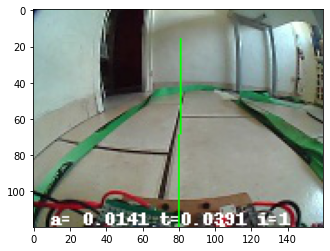

In [0]:
# Make Video of pilot steering/throttle (red) vs trained (green) 
# If you wan complete movie, incomment 'end = len(data)'
def get_point(s,start=0,end=160,height= 16):
    X = int(s*((end-start)/2)+(end-start)/2)
    if X < start:
        X = start
    if X > end:
        X = end
    return (X,height)

import numpy as np
from IPython.display import HTML

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
from IPython.display import display
from google.colab import files

start = 1
end = min(1000,len(images_pil_post))
print("Total :"+str(end))
#end = len(data)
print("Building Video")
fp = FloatProgress(min=0, max=end)
display(fp)
figure = plt.figure()
imageplot = plt.imshow(np.zeros((120,160, 3), dtype=np.uint8))
val_idx = 0
def next_frame(i):
    im = images_pil_post[i + val_idx].copy()
    draw = ImageDraw.Draw(im)
    p = get_point(angle_array[i + val_idx])
    draw.line((80,120, p, p),fill=(0,255,0,128))
#    if (len(pilot_throttle) >0):
#        pr = get_point(pilot_angle[i + val_idx])
#        draw.line((80,120, pr, pr),fill=(255,0,0,128)) 
#        draw.text((10,100),"pa= {:01.04f} pt={:01.04f}".format(pilot_angle[i + val_idx], pilot_throttle[i + val_idx]), fill=(255,255,255,128))
    draw.text((10,110),"a= {:01.04f} t={:01.04f} i={}".format(angle[i + val_idx], throttle[i + val_idx], i+val_idx), fill=(255,255,255,128))
    imageplot.set_array(im)
    fp.value += 1
    return imageplot,

animate = animation.FuncAnimation(figure, next_frame, frames=range(start, end), interval=60, blit=False)
fp.value=0
animate.save("video.mp4")


In [0]:
files.download("video.mp4")

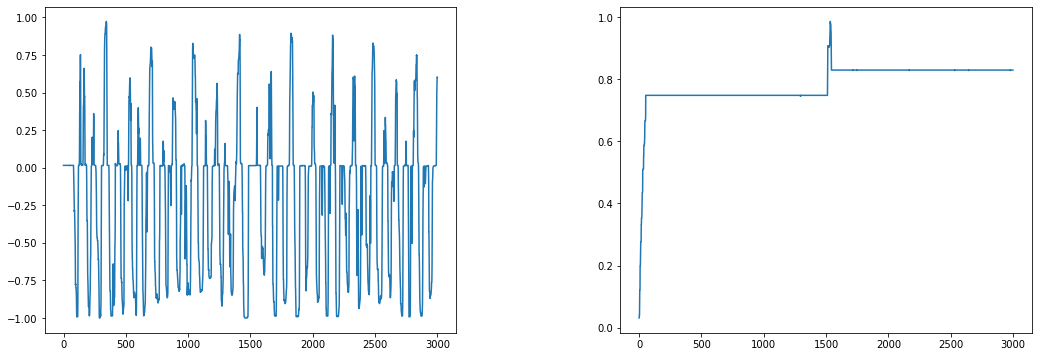

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(28, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
ax.plot(angle[0:3000])
ax = fig.add_subplot(1, 3, 2)
ax.plot(throttle[0:3000])


In [0]:
#load images

import gc


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

images = []
gc.collect()

#images = np.array([img_to_array(load_img(os.path.join(d[3],d[4]))) for d in data],'f
#for img in images_pil:
#    images = np.append(images, np.array([img_to_array(img)],'f'))
#    fp.value += 1
if (shuffleAtTheEnd):
  images = np.array([img_to_array(images_pil_post[idx]) for idx in permutation],'f')
else:
  images = np.array([img_to_array(img) for img in images_pil_post],'f')

In [0]:
print(images_pil_post[0].format, images_pil_post[0].size, images_pil_post[0].mode)

None (160, 120) RGB


In [0]:
#Train (old categorical model, one shot)

import numpy as np
from keras.layers import Input, Dense, merge
from keras.models import Model , Sequential
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
drops=0.1

save_best = callbacks.ModelCheckpoint(model_file_base, monitor='angle_out_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='angle_out_loss', 
                                                   min_delta=.0005, 
                                                   patience=30, 
                                                   verbose=1, 
                                                   mode='auto')
img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB

x = img_in
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output of the angle
callbacks_list = [save_best, early_stop]
angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
throttle_out = Dense(1, activation='relu', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

# Quantization aware training
sess = tf.keras.backend.get_session()
tf.contrib.quantize.create_training_graph(sess.graph)
sess.run(tf.global_variables_initializer())

model.compile(optimizer='adam',
              loss={'angle_out': 'categorical_crossentropy',
                    'throttle_out': 'mean_absolute_error'},
              loss_weights={'angle_out': 0.9, 'throttle_out': .001})
model.fit({'img_in':images},{'angle_out': angle_cat_array, 'throttle_out': throttle_array}, validation_split=0.15, batch_size=32, epochs=100, verbose=1, callbacks=callbacks_list)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Train on 20099 samples, validate on 3547 samples
Epoch 1/100
20099/20099 [==============================] - 27s 1ms/step - loss: 1.7866 - angle_out_loss: 1.9837 - throttle_out_loss: 0.4837 - val_loss: 1.5738 - val_angle_out_loss: 1.7478 - val_throttle_out_loss: 0.3054

Epoch 00001: angle_out_loss improved from inf to 1.98375, saving model to ./models/model_cat_27042020
Epoch 2/100
20099/20099 [==============================] - 20s 1ms/step - loss: 1.4133 - angle_out_loss: 1.5691 - throttle_out_loss: 0.2953 - val_loss: 1.4365 - val_angle_out_loss: 

KeyboardInterrupt: ignored

In [0]:
#Train (latest categorical model, one shot)

import numpy as np
from keras.layers import Input, Dense, merge
from keras.models import Model , Sequential
from keras.layers import Cropping2D, Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
drops=0.4

save_best = callbacks.ModelCheckpoint(model_file_base, monitor='angle_out_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='angle_out_loss', 
                                                   min_delta=.0005, 
                                                   patience=30, 
                                                   verbose=1, 
                                                   mode='auto')
img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB

x = img_in
x = Cropping2D(cropping=(roi_top_bottom_crop, (0,0)))(x) #trim pixels off top and bottom
x = BatchNormalization()(x)
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output of the angle
callbacks_list = [save_best, early_stop]
angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
throttle_out = Dense(20, activation='softmax', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

# Quantization aware training
sess = tf.keras.backend.get_session()
tf.contrib.quantize.create_training_graph(sess.graph)
sess.run(tf.global_variables_initializer())

model.compile(optimizer='adam',metrics=['acc'],
              loss={'angle_out': 'categorical_crossentropy',
                    'throttle_out': 'categorical_crossentropy'},
              loss_weights={'angle_out': 0.5, 'throttle_out': 1.0})
model.fit({'img_in':images},{'angle_out': angle_cat_array, 'throttle_out': throttle_cat_array}, validation_split=0.15, batch_size=32, epochs=100, verbose=1, callbacks=callbacks_list)


Train on 20099 samples, validate on 3547 samples
Epoch 1/100
20099/20099 [==============================] - 18s 913us/step - loss: 2.9543 - angle_out_loss: 2.4127 - throttle_out_loss: 1.7478 - val_loss: 2.7803 - val_angle_out_loss: 2.3811 - val_throttle_out_loss: 1.5900

Epoch 00001: angle_out_loss improved from inf to 2.41271, saving model to ./models/model_cat_27042020
Epoch 2/100
20099/20099 [==============================] - 17s 831us/step - loss: 2.7488 - angle_out_loss: 2.2804 - throttle_out_loss: 1.6083 - val_loss: 2.8096 - val_angle_out_loss: 2.4370 - val_throttle_out_loss: 1.5912

Epoch 00002: angle_out_loss improved from 2.41271 to 2.28040, saving model to ./models/model_cat_27042020
Epoch 3/100
20099/20099 [==============================] - 17s 827us/step - loss: 2.6760 - angle_out_loss: 2.1742 - throttle_out_loss: 1.5898 - val_loss: 2.8799 - val_angle_out_loss: 2.5698 - val_throttle_out_loss: 1.5953

Epoch 00003: angle_out_loss improved from 2.28040 to 2.17416, saving model

KeyboardInterrupt: ignored

In [0]:
#Train (latest categorical steering only model, one shot)

import numpy as np
from keras.layers import Input, Dense, merge
from keras.models import Model , Sequential
from keras.layers import Cropping2D, Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
drops=0.4

save_best = callbacks.ModelCheckpoint(model_file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                                   min_delta=.0005, 
                                                   patience=30, 
                                                   verbose=1, 
                                                   mode='auto')
img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB

x = img_in
x = Cropping2D(cropping=(roi_top_bottom_crop, (0,0)))(x) #trim pixels off top and bottom
x = BatchNormalization()(x)
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output of the angle
callbacks_list = [save_best, early_stop]
angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

model = Model(inputs=[img_in], outputs=[angle_out])

# Quantization aware training
sess = tf.keras.backend.get_session()
tf.contrib.quantize.create_training_graph(sess.graph)
sess.run(tf.global_variables_initializer())

model.compile(optimizer='adam',metrics=['acc'],
              loss={'angle_out': 'categorical_crossentropy'},
              loss_weights={'angle_out': 2.0})
model.fit({'img_in':images},{'angle_out': angle_cat_array}, validation_split=0.15, batch_size=32, epochs=100, verbose=1, callbacks=callbacks_list)


Train on 20099 samples, validate on 3547 samples
Epoch 1/100
20099/20099 [==============================] - 18s 891us/step - loss: 4.5808 - acc: 0.3439 - val_loss: 4.9009 - val_acc: 0.2721

Epoch 00001: val_loss improved from inf to 4.90093, saving model to ./models/model_cat_27042020
Epoch 2/100
20099/20099 [==============================] - 16s 788us/step - loss: 4.2698 - acc: 0.3733 - val_loss: 5.2525 - val_acc: 0.2588

Epoch 00002: val_loss did not improve from 4.90093
Epoch 3/100
20099/20099 [==============================] - 16s 792us/step - loss: 4.1755 - acc: 0.3838 - val_loss: 5.1524 - val_acc: 0.2673

Epoch 00003: val_loss did not improve from 4.90093
Epoch 4/100
20099/20099 [==============================] - 16s 802us/step - loss: 4.1272 - acc: 0.3857 - val_loss: 5.0851 - val_acc: 0.2684

Epoch 00004: val_loss did not improve from 4.90093
Epoch 5/100
20099/20099 [==============================] - 16s 795us/step - loss: 4.1019 - acc: 0.3865 - val_loss: 5.1858 - val_acc: 0.263

KeyboardInterrupt: ignored

In [0]:
#Train (latest linear model, one shot, the one tu use for now)

import numpy as np
from keras.layers import Input, Dense, merge
from keras.models import Model , Sequential
from keras.layers import Cropping2D, Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks

tf.keras.backend.clear_session()
try:
    model
except NameError:
    print("well, model it not defined after all!")
else:
    print("model alrady exist, clean it.")
    del model

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
drops=0.1

save_best = callbacks.ModelCheckpoint(model_file_base, monitor='angle_out_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='angle_out_loss', 
                                                   min_delta=.0005, 
                                                   patience=10, 
                                                   verbose=1, 
                                                   mode='auto')
img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB

x = img_in
#x = Cropping2D(cropping=(roi_top_bottom_crop, (0,0)))(x) #trim pixels off top and bottom
x = BatchNormalization()(x)
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output of the angle
callbacks_list = [save_best, early_stop]
angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
mark_out = Dense(3, activation='softmax', name='mark_out')(x)        

model = Model(inputs=[img_in], outputs=[angle_out, throttle_out, mark_out])

# Quantization aware training
sess = tf.keras.backend.get_session()
tf.contrib.quantize.create_training_graph(sess.graph)
sess.run(tf.global_variables_initializer())

model.compile(optimizer='adam',loss='mse')
model.fit({'img_in':images},{'angle_out': angle_array, 'throttle_out': throttle_array, 'mark_out' : mark_cat_array}, validation_split=0.15, batch_size=32, epochs=100, verbose=1, callbacks=callbacks_list)


well, model it not defined after all!
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Train on 19182 samples, validate on 3386 samples
Epoch 1/100
19182/19182 [==============================] - 20s 1ms/step - loss: 0.1279 - angle_out_loss: 0.0765 - throttle_out_loss: 0.0445 - mark_out_loss: 0.0069 - val_loss: 0.0841 - val_angle_out_loss: 0.0562 - val_throttle_out_loss: 0.0267 - val_mark_out_loss: 0.0012

Epoch 00001: angle_out_loss improved from inf to 0.07648, saving model to ./models/model_cat_14052020
Epoch 2/100
19182/19182 [==============================] - 13s 693us/step - loss: 0.0614 - 

In [0]:
#Train (new categorical model, TF2, one shot, WIP)

import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import callbacks
import tensorflow_model_optimization as tfmot

def model(x, training, scope='model'):
  with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
    x = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu,
          kernel_regularizer=tf.contrib.layers.l2_regularizer(0.04))
    x = tf.layers.max_pooling2d(x, (2, 2), 1)
    x = tf.layers.flatten(x)
    x = tf.layers.dropout(x, 0.1, training=training)
    x = tf.layers.dense(x, 64, activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, training=training)
    x = tf.layers.dense(x, 10)
    return x
    
save_best = callbacks.ModelCheckpoint(model_file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                                   min_delta=.0005, 
                                                   patience=10, 
                                                   verbose=1, 
                                                   mode='auto')
callbacks_list = [save_best, early_stop]

drop = 0.1
mode=tf.keras.Sequential([
  Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1"),
  Dropout(drop),
  Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2"),
  Dropout(drop),
  Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3"),
  Convolution2D(64, (3,3), strides=(2,2), activation='relu', name="conv2d_4"),
  Dropout(drop),
  Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5"),
  Dropout(drop)(x),
  Flatten(name='flattened'),
  Dense(100, activation='relu', name="fc_1"),
  Dropout(drop),
  Dense(50, activation='relu', name="fc_2"),
  Dropout(drop),
  Dense(15, activation='softmax', name='angle_out')]);

#img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
#x = img_in
#x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
#x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
#x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
#x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
#x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
#x = Convolution2D(64, (3,3), strides=(2,2), activation='relu', name="conv2d_4")(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
#x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
#x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
#x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

#x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
#x = Dense(100, activation='relu', name="fc_1")(x)                                    # Classify the data into 100 features, make all negatives 0
#x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
#x = Dense(50, activation='relu', name="fc_2")(x)                                     # Classify the data into 50 features, make all negatives 0
#x = Dropout(drop)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
#categorical output of the angle
#angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

model = Model(inputs=[img_in], outputs=[angle_out])

# Quantization aware training
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

#q_aware_model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

q_aware_model.compile(optimizer='adam',
              loss={'quant_angle_out': 'categorical_crossentropy'},
              loss_weights={'quant_angle_out': 0.9})

q_aware_model.fit(images,angle_cat_array, validation_split=0.15, batch_size=32, epochs=1, verbose=1, callbacks=callbacks_list)



250/250 [==============================] - ETA: 0s - loss: 2.2778
Epoch 00001: val_loss improved from inf to 2.30793, saving model to ./models/model_cat_20042020
INFO:tensorflow:Assets written to: ./models/model_cat_20042020/assets
250/250 [==============================] - 10s 42ms/step - loss: 2.2778 - val_loss: 2.3079


In [0]:
#Train (new linear model, TF2, one shot, WIP)
#Train (Quantitized latest linear model, TF2, one shot)

import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Cropping2D, Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import callbacks


#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
drops=0.1

save_best = callbacks.ModelCheckpoint(model_file_base, monitor='angle_out', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='angle_out', 
                                                   min_delta=.0005, 
                                                   patience=30, 
                                                   verbose=1, 
                                                   mode='auto')
img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB

x = img_in
x = Cropping2D(cropping=(roi_top_bottom_crop, (0,0)))(x) #trim pixels off top and bottom
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output of the angle
callbacks_list = [save_best, early_stop]
angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

model.compile(optimizer='adam',
              loss={'angle_out':'categorical_crossentropy'},
              metrics=['accuracy'])
model.fit({'img_in':images},{'angle_out': angle_array, 'throttle_out': throttle_array}, validation_split=0.15, batch_size=32, epochs=100, verbose=1, callbacks=callbacks_list)


Epoch 1/100
447/679 [==================>...........] - ETA: 7s - loss: -2.4286e-08 - angle_out_loss: -2.4286e-08 - angle_out_accuracy: 0.0096 - throttle_out_accuracy: 0.0060

KeyboardInterrupt: ignored

In [0]:
# Download TF model
from google.colab import files
files.download(model_file_base)

In [0]:
#Train (Quantitized latest linear model, TF2, one shot)

import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Cropping2D, Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import callbacks
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
drops=0.1

save_best = callbacks.ModelCheckpoint(model_file_base, monitor='quant_angle_out_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='quant_angle_out_loss', 
                                                   min_delta=.0005, 
                                                   patience=30, 
                                                   verbose=1, 
                                                   mode='auto')
img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB

x = img_in
x = Cropping2D(cropping=(roi_top_bottom_crop, (0,0)))(x) #trim pixels off top and bottom
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(drops)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output of the angle
callbacks_list = [save_best, early_stop]
angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

# Quantization aware training
q_aware_model = quantize_model(model)

q_aware_model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
q_aware_model.fit({'img_in':images},{'quant_angle_out': angle_array, 'quant_throttle_out': throttle_array}, validation_split=0.15, batch_size=32, epochs=100, verbose=1, callbacks=callbacks_list)


Epoch 1/100
679/679 [==============================] - ETA: 0s - loss: 0.3223 - quant_angle_out_loss: 0.2940 - quant_throttle_out_loss: 0.0283 - quant_angle_out_accuracy: 0.0000e+00 - quant_throttle_out_accuracy: 0.0066
Epoch 00001: quant_angle_out_loss improved from inf to 0.29400, saving model to ./models/model_cat_08052020
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/model_cat_08052020/assets
679/679 [==============================] - 26s 39ms/step - loss: 0.3223 - quant_angle_out_loss: 0.2940 - quant_throttle_out_loss: 0.0283 - quant_angle_out_accuracy: 0.0000e+00 - quant_throttle_out_accuracy: 0.0066 - val_loss: 0.3456 - val_quant_angle_out_loss: 0.3172 - val_quant_throttle_out_loss: 0.0284 - val_quant_angle_out_accuracy: 0.0000e+00 - val_quant_throttle_out_accuracy: 0.0060
Epoch 2/100
679/679 [==============================] - ETA: 0s - loss: 0.3157 - quant_angle_out_loss: 0.2914 - quant_throttle_out_

KeyboardInterrupt: ignored

In [0]:
q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 120, 160, 3)  3           img_in[0][0]                     
__________________________________________________________________________________________________
quant_cropping2d (QuantizeWrapp (None, 80, 160, 3)   1           quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_conv2d (QuantizeWrapper)  (None, 38, 78, 24)   1875        quant_cropping2d[0][0]           
______________________________________________________________________________________________

In [0]:
#convert Quantiwed model to TF Lite, optimized for TPU, and download
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()
open (model_file_base+"-edgetpu.tflite" , "wb").write(quantized_tflite_model)

ValueError: ignored

In [0]:
# Download TF Lite model
from google.colab import files
files.download(model_file_base+"-edgetpu.tflite")

In [0]:
# Upload a model and work on it
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  model_file_base = fn

Saving model_cat_14052020 to model_cat_14052020


In [0]:
#Download trained model
from google.colab import files
files.download(model_file_base)

In [0]:
# Convert trained model to TF and download it
from google.colab import files
print (model_file_base)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(model_file_base)
converter.optimizations = [tf.compat.v1.lite.Optimize.DEFAULT]

tfmodel = converter.convert()
open (model_file_base+".tflite" , "wb") .write(tfmodel)
files.download(model_file_base+".tflite")


./models/model_cat_08052020


KeyError: ignored

In [0]:
#For TF 1.x/Keras model
#Post training Full integer quantization of weights and activations, then export as tflite model
from google.colab import files
import tensorflow as tf

def representative_dataset_gen():
  calibration_images = images[:1000]
  for i in range(1000):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [images[i:i+1]]

converter = tf.lite.TFLiteConverter.from_keras_model_file(model_file_base)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_postquant_model = converter.convert()

open (model_file_base+"-postquant.tflite" , "wb") .write(tflite_postquant_model)
files.download(model_file_base+"-postquant.tflite")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 24 variables.
INFO:tensorflow:Converted 24 variables to const ops.
